# 如何使用此Colab檔案?


1.   將整份[資料夾](https://drive.google.com/file/d/1EzvulULvZgJeLVccogIJmv8hyBDRu6xp/view?usp=sharing)載下來後，將**資料夾上傳至自己雲端硬碟的首頁**。
2.   執行整份程式碼。

註: 若要更改資料夾位置，請在`folder_path`變數中，填入**資料夾位於自己雲端硬碟的位置。**

In [ ]:
# global variable (請在這裡填入必填資訊)
folder_path = '/content/drive/MyDrive/資產配置/' # Optional: 自行更動folder位置時才需修改

# Colab Package Install

In [ ]:
! pip install ffn > log.txt
! pip install finlab > log.txt
! pip install pybind11 > log.txt
! pip install cvxpy > log.txt
! pip install riskfolio-lib > log.txt
! pip install ta-lib-bin > log.txt
!python -m pip uninstall matplotlib -y > log.txt
! pip install matplotlib==3.6.3 > log.txt
! python -m pip uninstall pandas -y > log.txt
! pip install pandas==1.5.0 > log.txt

# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

--2023-03-01 10:08:13--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.203.102, 74.125.203.100, 74.125.203.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.203.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i44vem299sepmuguuhbdnngggjb9fn11/1677665250000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=7d7f94e6-d002-4b33-a2f4-afbd557bc650 [following]
--2023-03-01 10:08:15--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i44vem299sepmuguuhbdnngggjb9fn11/1677665250000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=7d7f94e6-d002-4b33-a2f4-afbd557bc650
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 142.251.8.132, 2404:6800:4008:c15::84
Connecting to doc-0k-

# 環境設定

In [ ]:
import finlab
from finlab import data
from finlab.backtest import sim
from finlab.dataframe import FinlabDataFrame
import numpy as np
import pandas as pd
import ffn
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
from matplotlib.font_manager import fontManager
import seaborn as sns
import warnings
import riskfolio as rp
import random
import pickle
from tqdm import tqdm


warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use('seaborn')
height, aspect = 4, 2
plt.rcParams['figure.figsize'] = (height * aspect, height)

# ========================== 字體 & 檔案路徑設定 ==========================

# Colab版本
from google.colab import drive
drive.mount('/content/drive')

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


Mounted at /content/drive


# FinLab VIP 策略分析

## FinLab VIP策略績效表現作圖

<AxesSubplot:title={'center':'FinLab VIP Strategy Portfolio Performance'}, xlabel='date'>

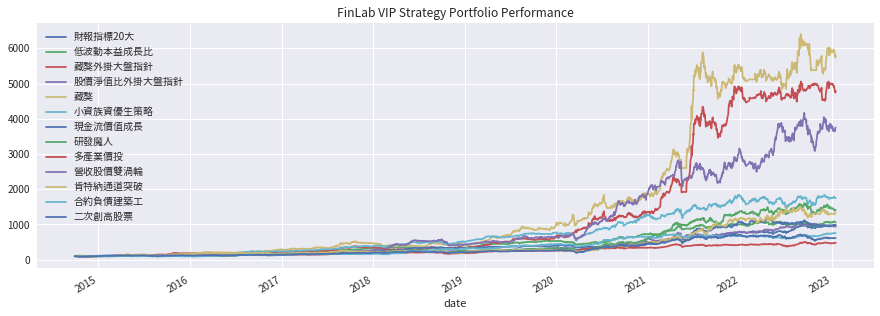

In [ ]:
# 讀取portfolioPrice.csv，計算波動度、年報酬率作圖
finalPortfolioPrice = pd.read_csv(folder_path+"portfolioPrice.csv",index_col=0)
finalPortfolioPrice.index = pd.to_datetime(finalPortfolioPrice.index)
returns = finalPortfolioPrice.to_returns().dropna()
perf = finalPortfolioPrice.calc_stats()
perf.plot(title="FinLab VIP Strategy Portfolio Performance")

## 計算報酬均值、標準差、夏普比率、最大回撤

In [ ]:
# calculate return, std, mdd
retMean = returns.mean()
retStd = returns.std()
sharpe = retMean / retStd * np.sqrt(252)
mdd = finalPortfolioPrice.calc_max_drawdown().abs()

## 針對報酬均值&波動度作散佈圖

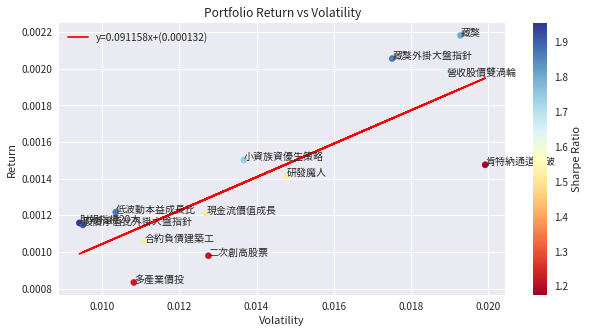

In [ ]:
# ========================== plot scatter chart (dot with label beside) ===========================
plt.figure(figsize=(10, 5))
for i, txt in enumerate(retStd.index):
    # plt.scatter(retStd[i], retMean[i], marker='o', s=5)
    plt.annotate(txt, (retStd[i], retMean[i]), fontsize=10)
plt.scatter(retStd, retMean, c=sharpe, cmap='RdYlBu', marker='o', s=40)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Portfolio Return vs Volatility')

# plot regression line(with label)
z = np.polyfit(retStd, retMean, 1)
p = np.poly1d(z)
plt.plot(retStd, p(retStd), "r", label="y=%.6fx+(%.6f)" % (z[0], z[1]))
plt.legend()
plt.show()

## 針對報酬均值&最大回撤作散佈圖

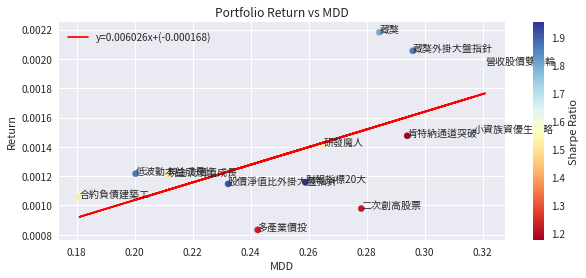

In [ ]:
# ============================= plt mdd return (with label) ===================================
plt.figure(figsize=(10, 4))
for i, txt in enumerate(retStd.index):
    plt.annotate(txt, (mdd[i], retMean[i]), fontsize=10)
plt.scatter(mdd,retMean, c=sharpe, cmap='RdYlBu', marker='o', s=40)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('MDD')
plt.ylabel('Return')
plt.title('Portfolio Return vs MDD')

# plot regression line(with label)
z = np.polyfit(mdd, retMean, 1)
p = np.poly1d(z)
plt.plot(mdd, p(mdd), "r", label="y=%.6fx+(%.6f)" % (z[0], z[1]))
plt.legend()
plt.show()

## 針對VIP策略作相關係數矩陣圖

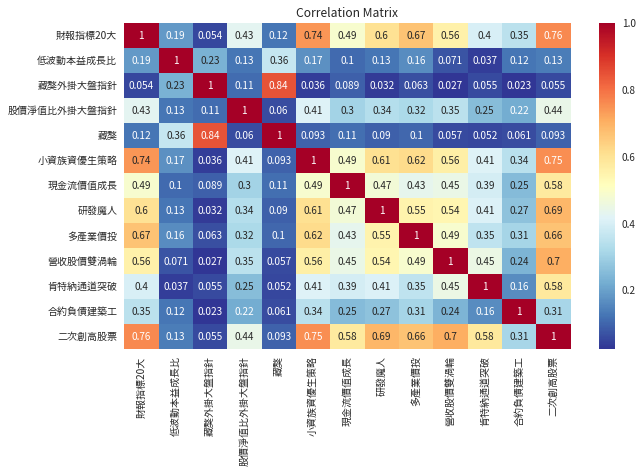

In [ ]:
# calculate correlation matrix
corr = finalPortfolioPrice.pct_change().dropna().corr()

# plot correlation matrix (cmap reverse)
plt.figure(figsize=(10, 6))
sns.heatmap(corr, cmap='RdYlBu_r', annot=True)
plt.title('Correlation Matrix')
plt.savefig(folder_path+'Correlation_Matrix.png')
plt.show()

# 資產配置程式碼

## 效率前緣 & Max Sharpe Ratio資產配置組合示範

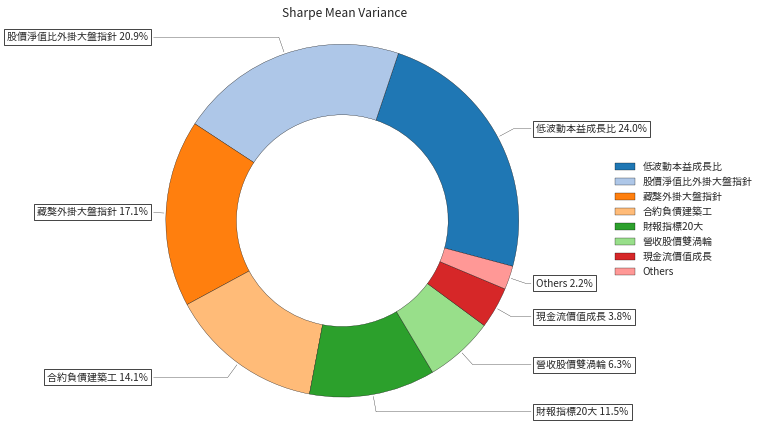

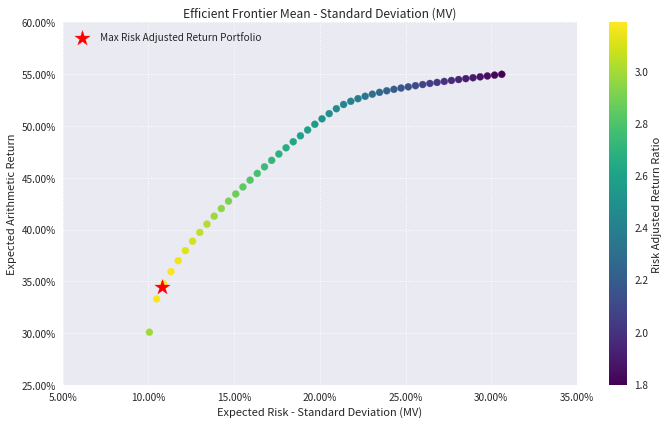

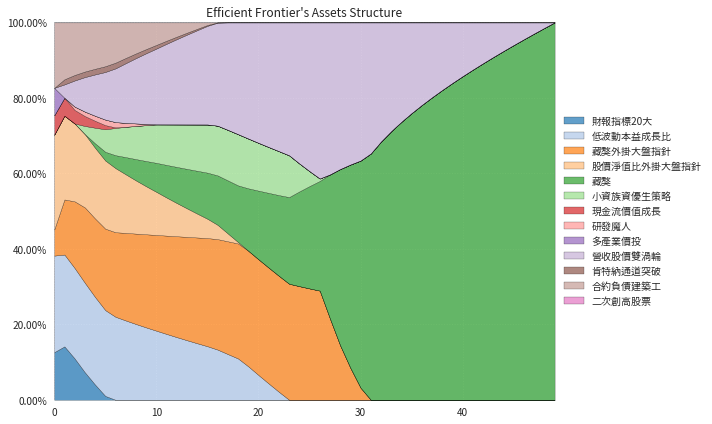

In [ ]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns.iloc[:,:]) # 可自行調整要放入哪些策略，去算出最佳組合，作為資金配置的依據
method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.
port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist) # provides the highest expected return per unit of risk


# Plotting the composition of the portfolio
ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",height=6, width=10, ax=None)
plt.savefig("myfig2.png", transparent=True)
plt.show()


# Plotting the efficient frontier
points = 50 # Number of points of the frontier
frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets
ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)
plt.show()


# Plotting efficient frontier composition
ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)
plt.show()

## 依據不同codependence measure進行分群，並儲存圖片

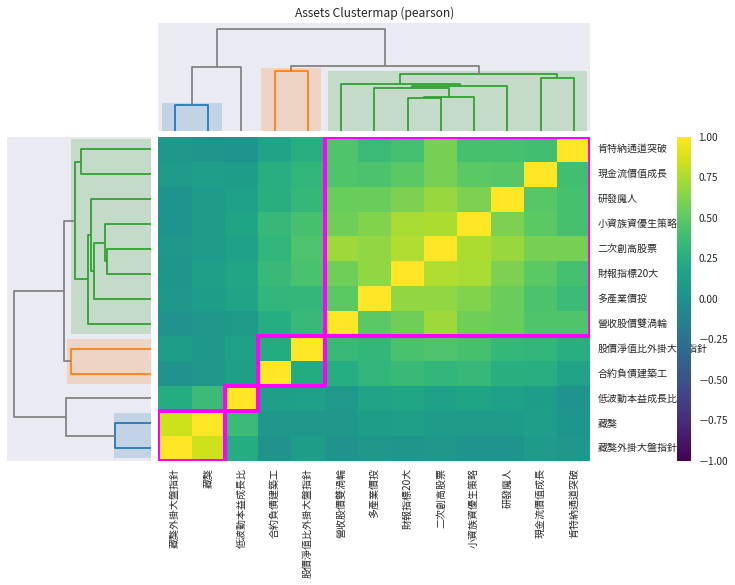

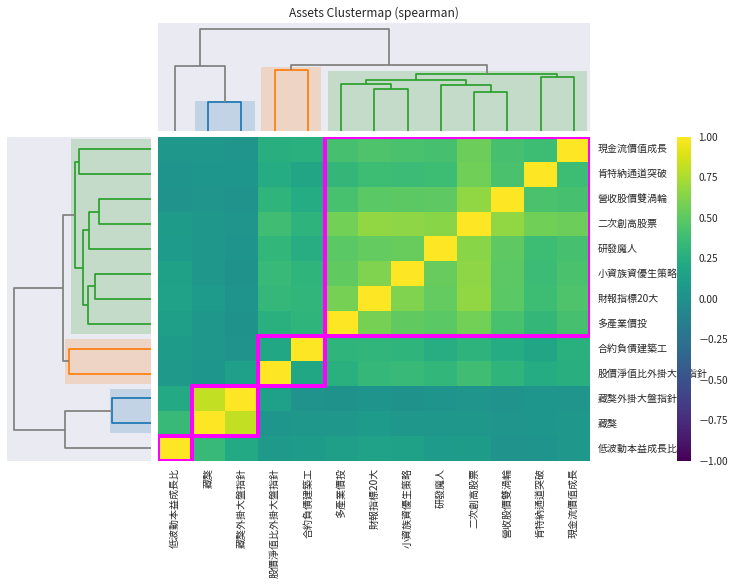

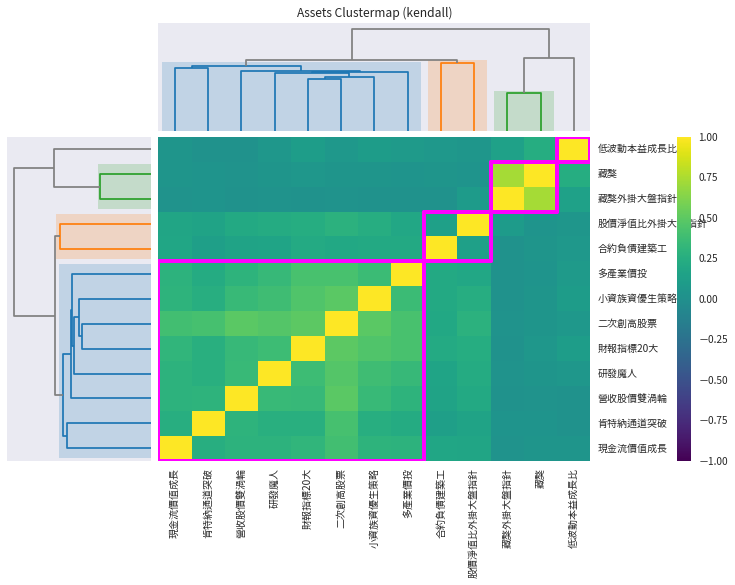

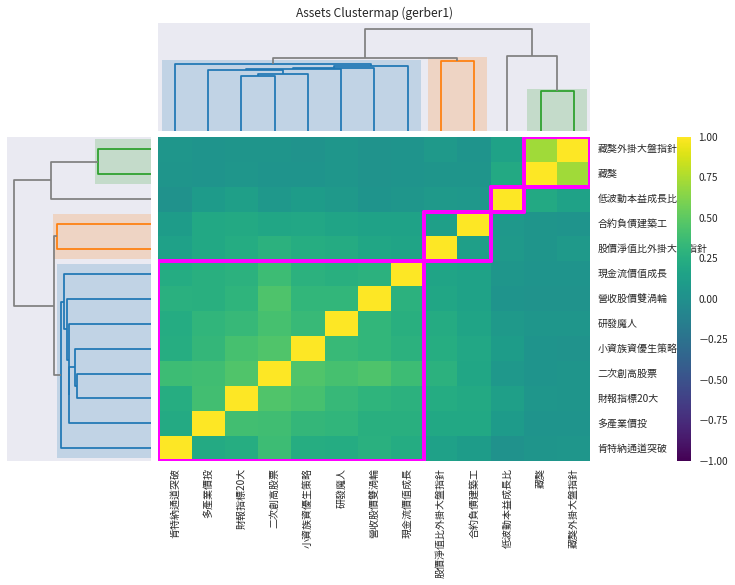

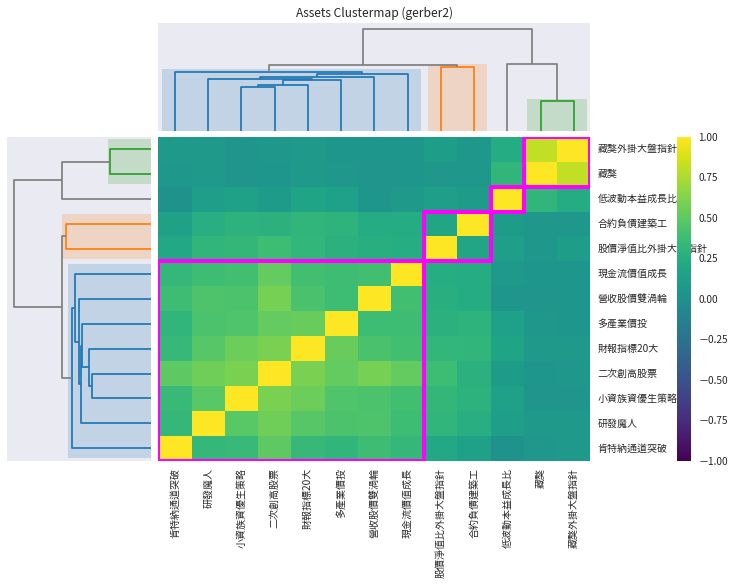

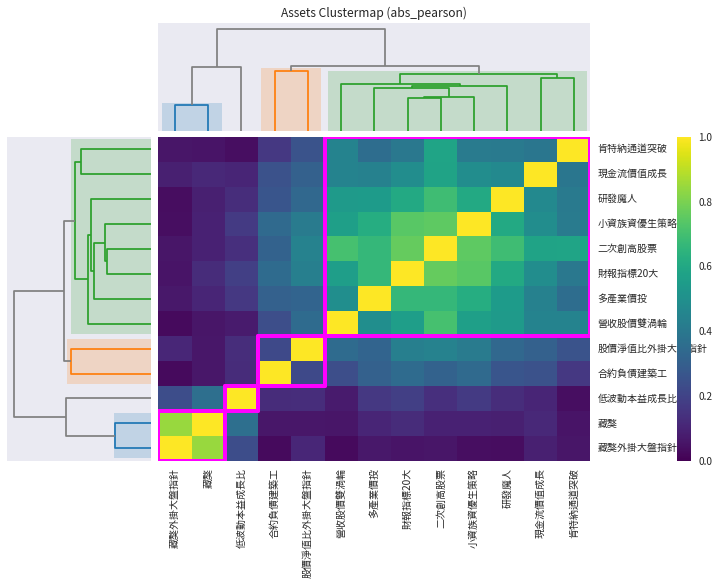

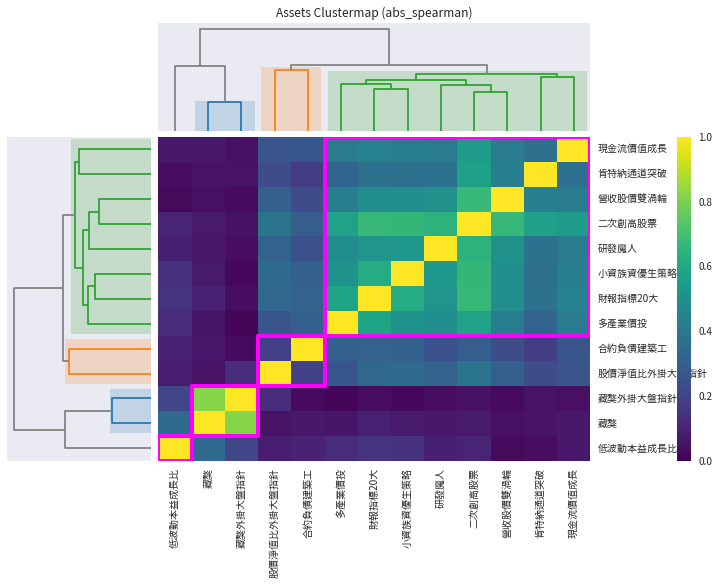

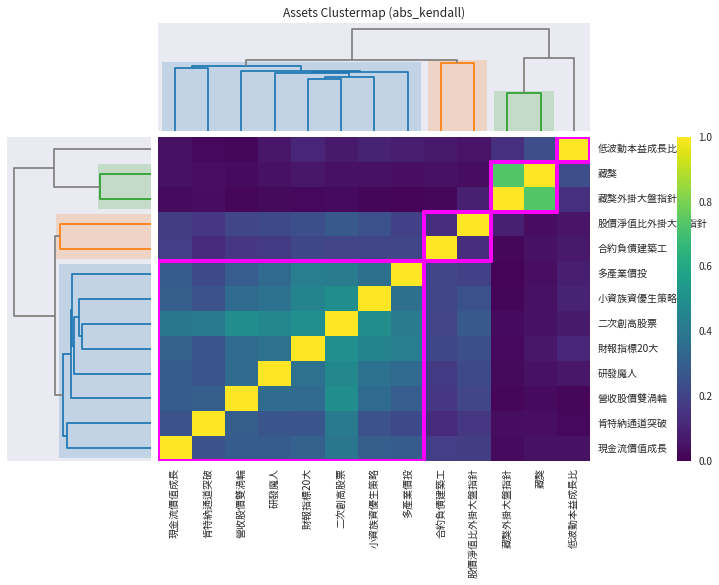

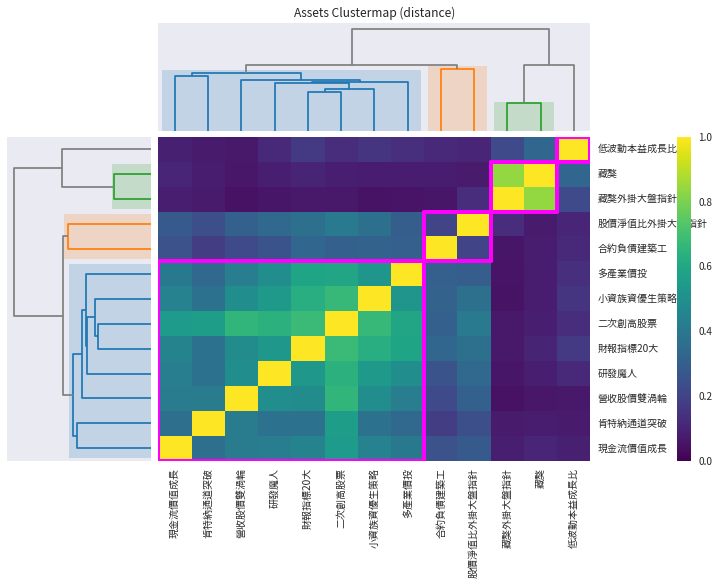

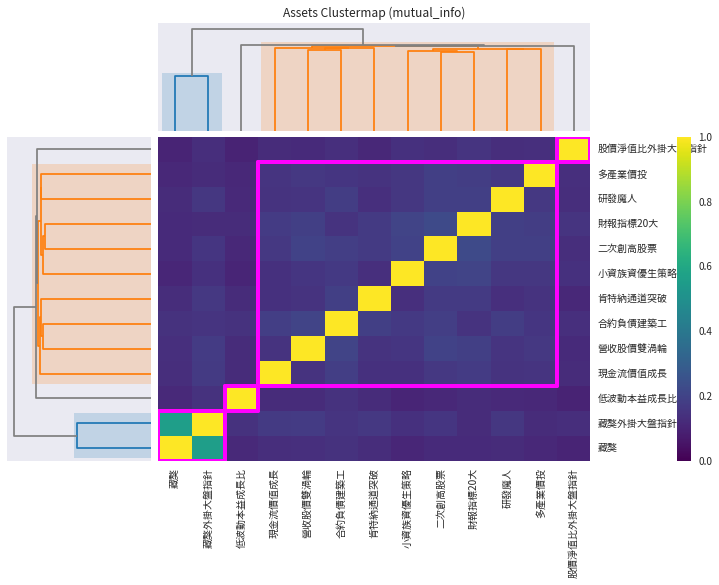

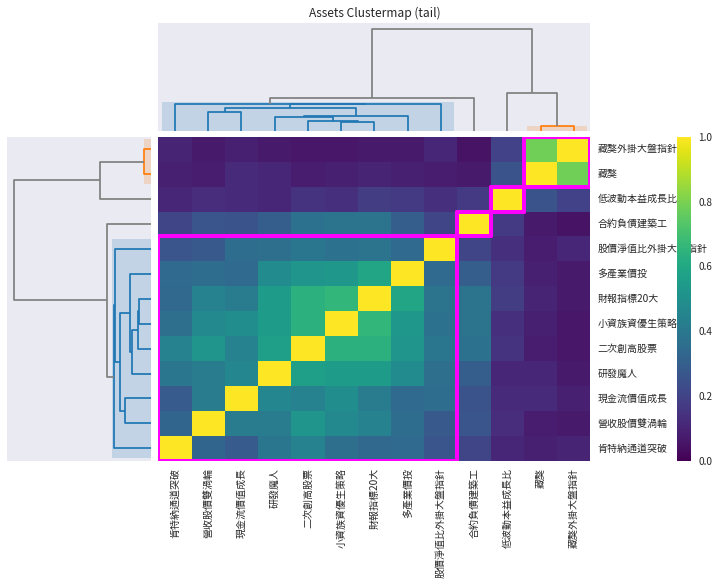

In [ ]:
# figure saved in folder_path
codependenceList = ['pearson','spearman','kendall','gerber1','gerber2','abs_pearson','abs_spearman','abs_kendall','distance','mutual_info','tail']
for codependence in codependenceList:
    rp.plot_clusters(returns=returns, codependence=codependence, height=7.5,width=10,title=f"Assets Clustermap ({codependence})")
    plt.savefig(folder_path+'cluster_'+codependence+'.png', dpi=300, bbox_inches='tight')
    plt.show()

# 透過回測尋找較佳的模型參數

## Random Search & Walk Forward Backtest函式撰寫

In [ ]:
def walkForwardBacktest(returns,nsamples=180,freq=20,**params):
  
  # initialize
  eqs = pd.Series()
  weights_history = pd.DataFrame(columns=returns.columns)
  dates = pd.date_range(start=finalPortfolioPrice.index[0], end='2023', freq='20D')
  
  print("Start Backtesting: ",params)

  for endDate, finalDate in zip(dates[1:], dates[2:]):
    
    # get data in startDate~endDate to adjust weight
    rollingReturns = returns.loc[:endDate].tail(nsamples)
    if len(rollingReturns) < nsamples:
      continue
    
    # build portfolio object
    HCPort = rp.HCPortfolio(rollingReturns)
    try:
      weights = HCPort.optimization(**params).T
    except Exception as e:
        print("Error: ", e)
        return

    # store weights in weight_history(empty data dataframe).
    weights_history.loc[endDate] = weights.values[0]

    # Calculate the rate of return after adjusting the weight for each period.
    eq = ((finalPortfolioPrice.loc[endDate:finalDate].rebase()  * weights.loc['weights']).sum(axis=1)).pct_change()
    eqs = eqs.append(eq)

  creturn = (eqs+1).cumprod()
  return creturn, weights_history


def random_param(returns):

  # 全部待測的參數組合
  modelList = ['HRP','HERC','HERC2','NCO']
  covarianceList = ['hist','ewma1','ewma2','ledoit','oas','shrunk','gl','jlogo','fixed','spectral','shrink','gerber1','gerber2']
  linkageList = ['single','complete','average','weighted','centroid','median','ward','DBHT']
  codependenceList = ['pearson','spearman','kendall','gerber1','gerber2','abs_pearson','abs_spearman','abs_kendall','distance','mutual_info','tail']
  rmList = ['equal','vol','MV','KT','MAD','MSV','SKT','FLPM','SLPM','VaR','CVaR','TG','EVaR','WR','RG','CVRG','TGRG','MDD','ADD','DaR','CDaR','EDaR','UCI','MDD_Rel','ADD_Rel','DaR_Rel','CDaR_Rel','EDaR_Rel','UCI_Rel']
  objList = ['MinRisk','Utility','Sharpe','ERC'] # only for NCO model
  
  # param_dict
  paramDict = {"modelList":modelList,"covarianceList":covarianceList,"linkageList":linkageList,"objList":objList,"codependenceList":codependenceList,"rmList":rmList}

  # 讀取現有的param檔案(.pkl)，確保還沒測過
  try:
    with open(folder_path+"newParamDict.pkl", "rb") as f:
      storedParamDict = pickle.load(f)
  except:
    storedParamDict = {}


  # 隨機挑選一個參數組合，若參數相同則重新random
  while(True):
    randomParamDict = {}
    for k,v in paramDict.items():
      randIndex = random.randint(0,len(v)-1)
      randomParamDict[k[:-4]] = v[randIndex]
    if str(randomParamDict) not in storedParamDict.keys():
      break


  # 跑回測
  try:
    creturn, weights_history = walkForwardBacktest(returns,**randomParamDict)
  except:
    return


  # 儲存結果(權益曲線、持股權重)到.pkl
  storedParamDict[str(randomParamDict)] = {"creturn":creturn,"weights_history":weights_history}
  with open(folder_path+"newParamDict.pkl", "wb") as f:
    pickle.dump(storedParamDict, f)

  pass

### 進行Random Search (次數自訂)

In [ ]:
target_count = 1
for i in tqdm(range(target_count)):
  random_param(returns)

100%|██████████| 1/1 [00:06<00:00,  6.92s/it]

Start Backtesting:  {'model': 'HERC', 'covariance': 'shrink', 'linkage': 'median', 'obj': 'ERC', 'codependence': 'abs_kendall', 'rm': 'MDD'}
Error:  division by zero


### 查看目前已測試過的參數組合數量

In [ ]:
with open(folder_path+"newParamDict.pkl", "rb") as f:
  storedParamDict = pickle.load(f)
print("已測試過的參數組合數量: ",len(storedParamDict))

已測試過的參數組合數量:  5000


# 查看各參數組合的績效表現

## 列出所有參數組和之績效、MDD

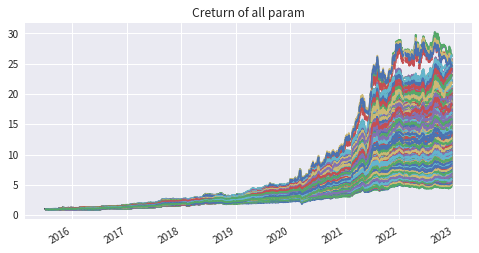

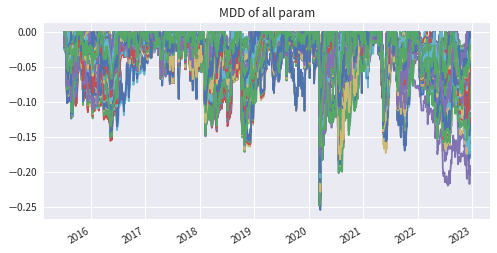

In [ ]:
# read data
with open(folder_path+"newParamDict.pkl", "rb") as f:
  storedParamDict = pickle.load(f)

df = pd.DataFrame()
for k,v in storedParamDict.items():
  df[k] = v['creturn']

# plot all creturn & MMD curve
df.plot(legend=False,title="Creturn of all param")
df.to_drawdown_series().plot(legend=False, title="MDD of all param")


# calculate std and mean of return
ret = df.dropna().rebase().pct_change()
retStd = ret.std() # series
retMean = ret.mean() # series
frontier = pd.concat([retStd,retMean],axis=1)
frontier.columns = ['std','mean']

# convert string to dict
def str2dict(string):
    string = string.replace(" ","").replace("'","").replace("{","").replace("}","")
    string = string.split(",")
    d = {}
    for i in string:
        d[i.split(":")[0]] = i.split(":")[1]
    return d

# convert index to columns
keys = str2dict(df.columns[0]).keys()
values = [[] for i in range(len(keys))]
columns = dict(zip(keys,values))

for idx in frontier.index:
    param = str2dict(idx)
    for k,v in param.items():
        columns[k].append(v)

frontier = pd.concat([frontier,pd.DataFrame(columns,index=frontier.index)],axis=1)

## 對5000種參數組合繪製效率前緣

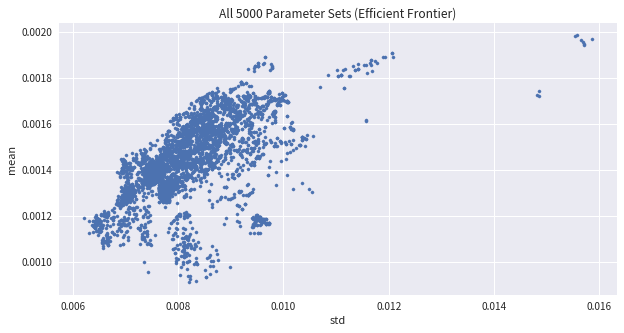

In [ ]:
# plot all dots without labeling
plt.figure(figsize=(10,5))
plt.scatter(frontier['std'],frontier['mean'],s=10)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('All 5000 Parameter Sets (Efficient Frontier)')
plt.show()

## 針對各參數作圖，顏色為該參數的不同類別
+ 風險(std)為x軸、報酬(均值)為y軸
+ 共會有6張圖(每個參數會獨立做一張)
+ 可看出參數特性、優劣，便於做進一步的探討

In [ ]:
frontier.sort_values('mean')

,std,mean,model,covariance,linkage,codependence,rm,obj
"{'model': 'NCO', 'covariance': 'hist', 'linkage': 'DBHT', 'codependence': 'abs_pearson', 'rm': 'CDaR', 'obj': 'Utility'}",0.008213,0.000912,NCO,hist,DBHT,abs_pearson,CDaR,Utility
"{'model': 'NCO', 'covariance': 'gl', 'linkage': 'DBHT', 'codependence': 'abs_spearman', 'rm': 'MDD', 'obj': 'MinRisk'}",0.008339,0.000917,NCO,gl,DBHT,abs_spearman,MDD,MinRisk
"{'model': 'NCO', 'covariance': 'gerber2', 'linkage': 'DBHT', 'codependence': 'abs_pearson', 'rm': 'EDaR', 'obj': 'Utility'}",0.008222,0.000928,NCO,gerber2,DBHT,abs_pearson,EDaR,Utility
"{'model': 'NCO', 'covariance': 'jlogo', 'linkage': 'DBHT', 'codependence': 'spearman', 'rm': 'MDD', 'obj': 'MinRisk'}",0.008537,0.000935,NCO,jlogo,DBHT,spearman,MDD,MinRisk
"{'model': 'NCO', 'covariance': 'oas', 'linkage': 'single', 'codependence': 'pearson', 'rm': 'MDD', 'obj': 'Utility'}",0.008529,0.000936,NCO,oas,single,pearson,MDD,Utility
...,...,...,...,...,...,...,...,...
"{'model': 'NCO', 'covariance': 'oas', 'linkage': 'average', 'codependence': 'abs_kendall', 'rm': 'MV', 'obj': 'Utility'}",0.015695,0.001958,NCO,oas,average,abs_kendall,MV,Utility
"{'model': 'NCO', 'covariance': 'fixed', 'linkage': 'DBHT', 'codependence': 'distance', 'rm': 'MV', 'obj': 'Utility'}",0.015658,0.001967,NCO,fixed,DBHT,distance,MV,Utility
"{'model': 'NCO', 'covariance': 'shrunk', 'linkage': 'average', 'codependence': 'kendall', 'rm': 'MV', 'obj': 'Utility'}",0.015854,0.001969,NCO,shrunk,average,kendall,MV,Utility
"{'model': 'NCO', 'covariance': 'jlogo', 'linkage': 'complete', 'codependence': 'abs_kendall', 'rm': 'MV', 'obj': 'Utility'}",0.015532,0.001981,NCO,jlogo,complete,abs_kendall,MV,Utility


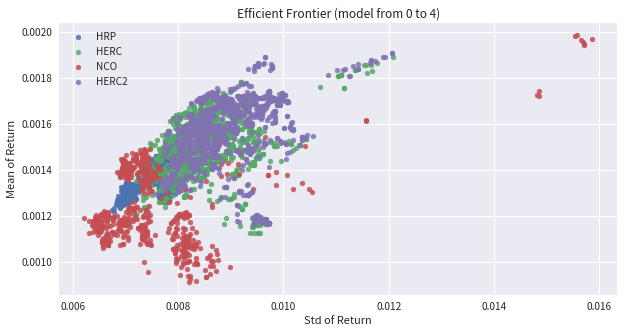

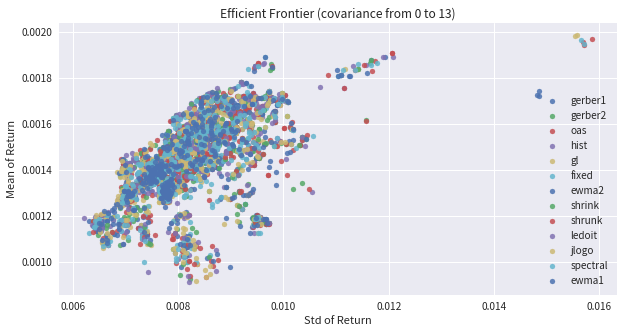

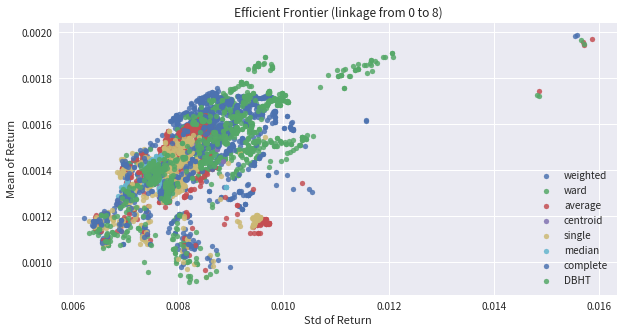

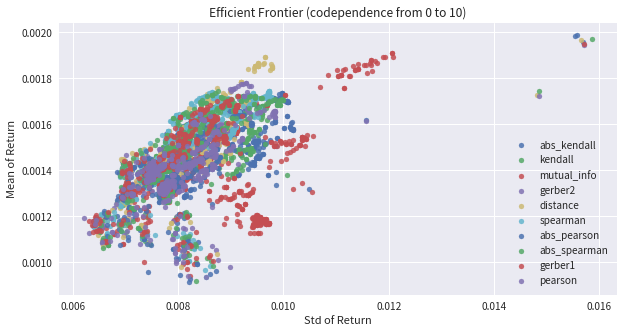

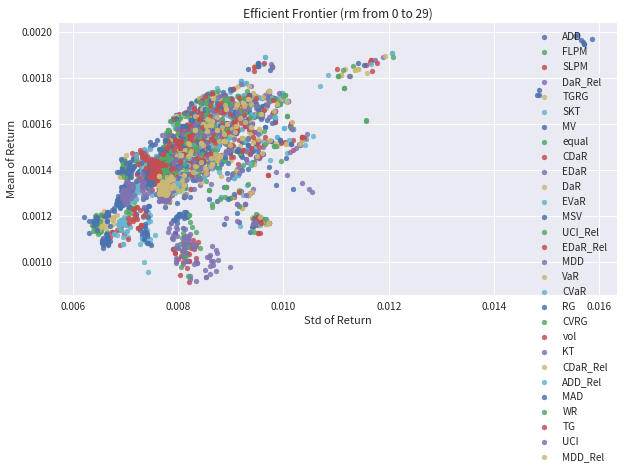

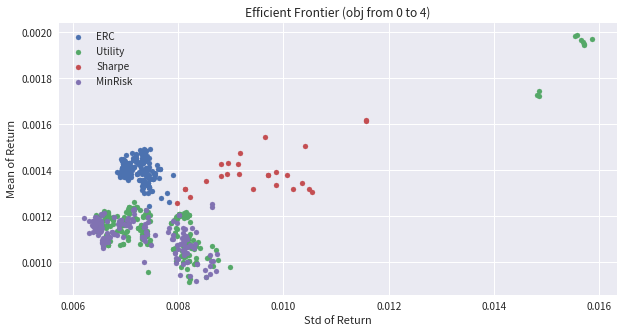

In [ ]:
# plot different color with different parameters
for param in frontier.columns[2:]:
    plt.figure(figsize=(10,5))
    # every five param in a plot
    stepSize = 100
    for i in range(0,len(frontier[param].unique()),stepSize):
        for p in frontier[param].unique()[i:i+stepSize]:
            # frontier[frontier['rm'] == 'MV']
            if param == "obj": # obj only work for NCO model
                plt.scatter(frontier[frontier["model"]=="NCO"][frontier[param]==p]['std'],frontier[frontier["model"]=="NCO"][frontier[param]==p]['mean'],label=p,alpha=1,s=25)
            else:
                plt.scatter(frontier[frontier[param]==p]['std'],frontier[frontier[param]==p]['mean'],label=p,alpha=0.85,s=25)
        start,end = str(i),str(min(i+stepSize,len(frontier[param].unique())))
        plt.title("Efficient Frontier"+" ("+param+" from "+start+" to "+end+")")
        plt.xlabel("Std of Return")
        plt.ylabel("Mean of Return")
        plt.legend()
        plt.show()

## 找出穩定、較佳的參數組合進行回測

Start Backtesting:  {'model': 'NCO', 'linkage': 'ward', 'obj': 'ERC'}


<AxesSubplot:>

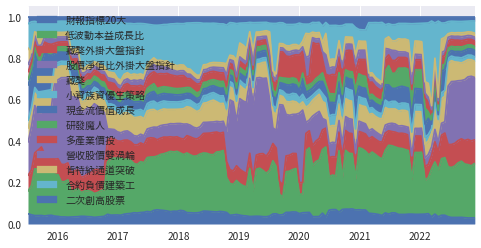

In [ ]:
pd.options.plotting.backend = "matplotlib"

# 指定model、linkage、obj，其他參數使用預設值
ParamDict = {'model': 'NCO',"linkage":'ward', 'obj': 'ERC'} 
creturn, weights_history = walkForwardBacktest(returns,**ParamDict)
creturn.name = "Final Portfolio"
creturn.dropna(inplace=True)

# 隨時間變化的資產配置變化
weights_history.plot.area()#(figsize=(15,5),title="Portfolio Weights")
#plt.show()

### 使用 ffn 計算最終績效表現
+ 雖然資產配置使用Walk forward optimization，但策略本身有一部分training data(受限於上線時間不夠長)，績效僅供參考

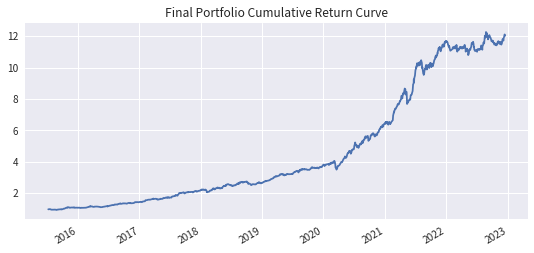

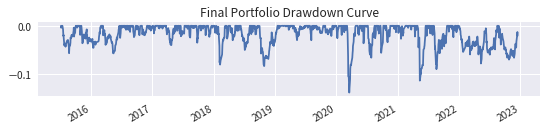

  Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct    Nov    Dec    YTD
------  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----
  2015   0      0      0      0      0      0     -2.86  -0.23   2.75  10.91   0.08  -0.08  10.44
  2016  -0.99   3.4    2.36   1.03  -0.91   4.89   4.19   7.24   1.23   2.75   0.16   3.48  32.55
  2017   3.07   7.52   2.99  -1.57   4.83   2.14   5.22  11.32  -0.42   2.72   4.01   1.55  52.2
  2018   0.72  -1.25   6.32   0.3    8.16   0.42   0.74   6.94   1.31  -7.38   2.93   1.05  21.12
  2019   5.38   4.6    5.67   3.51   1.16  -0.3    5.6    3.92  -1.24   3.38   0.21   5.04  43.42
  2020   1.85   1.72  -4.65  11.73   8.85   5.25   4.42   7.81   0.22   4.44   7.01   6.32  69.53
  2021   0.96  10.94   9.13  10.16  -8.14  20.85   6.66  -2.58   3      3.96   3.96   5.17  81.86
  2022  -5.38   1.52  -0.13  -1.07   2.77  -2.73   2.73   6.94  -4.16  -2.02   1.57   3.28   2.68


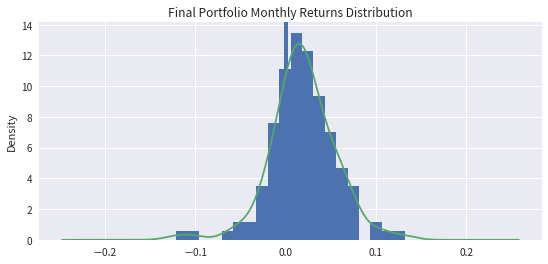

Stats for Final Portfolio from 2015-07-08 00:00:00 - 2022-12-16 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
1125.33%            3.18  40.04%  -13.75%

Annualized Returns:
mtd    3m      6m     ytd    1y     3y      5y      10y    incep.
-----  ------  -----  -----  -----  ------  ------  -----  --------
3.28%  -0.09%  6.25%  2.68%  5.08%  48.66%  41.17%  -      40.04%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  3.18     2.36       1.58
mean    36.13%   35.76%     43.34%
vol     11.37%   15.17%     27.42%
skew    -0.65    0.62       -0.04
kurt    3.69     2.60       -0.72
best    3.35%    20.85%     81.86%
worst   -4.42%   -8.14%     2.68%

Drawdowns:
max      avg       # days
-------  ------  --------
-13.75%  -1.48%      13.2

Misc:
---------------  -------
avg. up month    4.43%
avg. down month  -2.38%
up year %        100.00%
12

In [ ]:
# calculate performance
perf = creturn.calc_stats()

# plot creturn curve
perf.plot(figsize=(9,4), title = f'{creturn.name} Cumulative Return Curve')
plt.show()

# plot drawdown curve
dd = perf.drawdown
dd.plot(figsize=(9,1.5), title = f'{creturn.name} Drawdown Curve')
plt.show()

# plot monthly return distribution
perf.display_monthly_returns()
perf.plot_histogram(freq='20D',figsize=(9,4),title= f'{creturn.name} Monthly Returns Distribution')
plt.show()

# display summary stats table
perf.display()

### 與其他策略的績效波動度比較

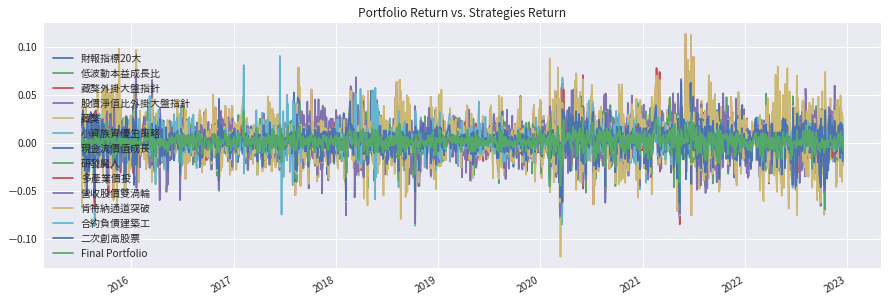

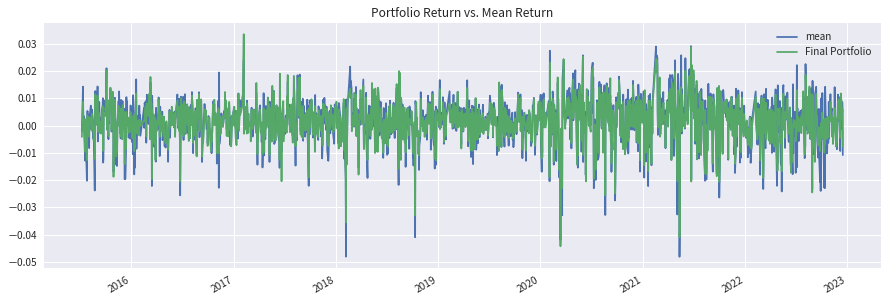

In [ ]:
portfolioReturn =  creturn / creturn.shift(1) - 1
portfolioReturn = portfolioReturn.dropna()
returns = returns.reindex(portfolioReturn.index)
returns['Final Portfolio'] = portfolioReturn
# plot portfolio return vs. strategies return
returns.plot(figsize=(15,5),title="Portfolio Return vs. Strategies Return")
plt.show()
returns['Final Portfolio X 1.25'] = portfolioReturn*1.25
returns['Final Portfolio X 1.5'] = portfolioReturn*1.5
returns['Final Portfolio X 1.75'] = portfolioReturn*1.75
returns['mean'] = returns.mean(axis=1) #平均持有
returns['mean X 1.25'] = returns['mean']*1.25
returns['mean X 1.5'] = returns['mean']*1.5
returns['mean X 1.75'] = returns['mean']*1.75

# plot portfolio return vs. mean return
returns[['mean','Final Portfolio']].plot(figsize=(15,5),title="Portfolio Return vs. Mean Return")
plt.show()

###  搭配槓桿後，與其他策略的對比 (Return & Volatility)

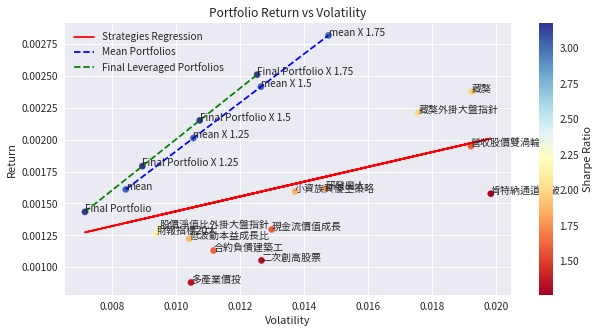

In [ ]:
# calculate return, std, mdd
retMean = returns.mean()
retStd = returns.std()
sharpe = retMean / retStd * np.sqrt(252)
mdd = finalPortfolioPrice.calc_max_drawdown().abs()

# mdd leverage simulation (without considering leverage cost)
finlab_strategy_mean = mdd.mean()
mdd['Final Portfolio'] = abs(perf.max_drawdown)
mdd['Final Portfolio X 1.25'] = abs(perf.max_drawdown)*1.25
mdd['Final Portfolio X 1.5'] = abs(perf.max_drawdown)*1.5
mdd['Final Portfolio X 1.75'] = abs(perf.max_drawdown)*1.75
mdd['mean'] = finlab_strategy_mean
mdd['mean X 1.25'] = finlab_strategy_mean*1.25
mdd['mean X 1.5'] = finlab_strategy_mean*1.5
mdd['mean X 1.75'] = finlab_strategy_mean*1.75

# ========================== plot scatter chart (dot with label beside) ===========================
plt.figure(figsize=(10, 5))
for i, txt in enumerate(retStd.index):
    # plt.scatter(retStd[i], retMean[i], marker='o', s=5)
    plt.annotate(txt, (retStd[i], retMean[i]), fontsize=10)
plt.scatter(retStd, retMean, c=sharpe, cmap='RdYlBu', marker='o', s=40)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Portfolio Return vs Volatility')

# plot regression line(with label)
z = np.polyfit(retStd[:-4], retMean[:-4], 1)
p = np.poly1d(z)
plt.plot(retStd, p(retStd), "r", label="Strategies Regression")

# plot regression line(with label)
z = np.polyfit(retStd[-4:], retMean[-4:], 1)
p = np.poly1d(z)
plt.plot(retStd[-4:], p(retStd[-4:]), "b", label="Mean Portfolios", linestyle='--')

# plot regression line(with label)
z = np.polyfit(retStd[-8:-4], retMean[-8:-4], 1)
p = np.poly1d(z)
plt.plot(retStd[-8:-4], p(retStd[-8:-4]), "g", label="Final Leveraged Portfolios", linestyle='--')

plt.legend(loc='upper left')
plt.show()

### 搭配槓桿後，與其他策略的對比 (Return & MDD)

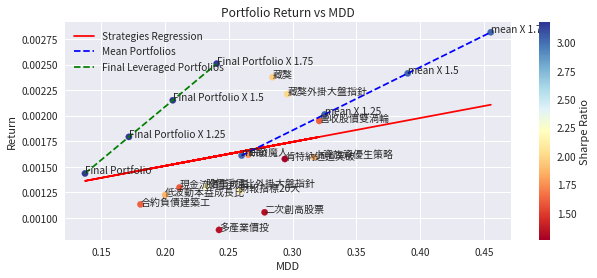

In [ ]:
# ============================= plt mdd return (with label) ===================================
plt.figure(figsize=(10, 4))
for i, txt in enumerate(retStd.index):
    plt.annotate(txt, (mdd[i], retMean[i]), fontsize=10)
plt.scatter(mdd,retMean, c=sharpe, cmap='RdYlBu', marker='o', s=40)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('MDD')
plt.ylabel('Return')
plt.title('Portfolio Return vs MDD')

# plot regression line(with label)
z = np.polyfit(mdd[:-4], retMean[:-4], 1)
p = np.poly1d(z)
plt.plot(mdd, p(mdd), "r", label="Strategies Regression")

# plot regression line(with label)
z = np.polyfit(mdd[-4:], retMean[-4:], 1)
p = np.poly1d(z)
plt.plot(mdd[-4:], p(mdd[-4:]), "b", label="Mean Portfolios", linestyle='--')

# plot regression line(with label)
z = np.polyfit(mdd[-8:-4], retMean[-8:-4], 1)
p = np.poly1d(z)
plt.plot(mdd[-8:-4], p(mdd[-8:-4]), "g", label="Final Leveraged Portfolios", linestyle='--')
plt.legend(loc='upper left')

plt.legend(loc='upper left')
plt.show()

# 個人化的槓桿試算器

In [ ]:
# input the highest risk level you can accept
acceptable_mmd = input("請輸入能承受的最大下跌幅度(%): ")
acceptable_mmd = abs(float(acceptable_mmd))
print("您能承受的最大下跌幅度為: ",acceptable_mmd,"%")

# calculate the leverage level
leverage_level = acceptable_mmd / abs(perf.max_drawdown)
print("所需的杠桿倍數為: ",round(leverage_level,2), "%")

# calculate the leveraged return
leveraged_return = perf.cagr * leverage_level
print("預計杠桿年報酬率為: ",round(leveraged_return,2), "%")

請輸入能承受的最大下跌幅度(%): 20
您能承受的最大下跌幅度為:  20.0 %
所需的杠桿倍數為:  145.47 %
預計杠桿年報酬率為:  58.24 %


# 補充教材 (2023/03)

## 如何使用自己策略製作portfolioPrice.csv?
+ 此處使用**三檔FinLab公開選股策略**進行示範，大家可依樣畫葫蘆生成自己策略的profolioPrice.csv，進行後續的資產配置。
+ [注意] 此處將檔案命名為**my_**portfolioPrice.csv，避免覆蓋掉原先csv檔案，大家可自行更換存檔名稱。

In [ ]:
portfolioPrice = pd.DataFrame()
strategyNames = ["股價淨值比策略","本益成長比策略","三頻率RSI策略"]
strategyReturns = {} # {key:value} = {策略名稱:策略日報酬}

# Strategy 1 - 股價淨值比策略
收盤價 = data.get('price:收盤價')
股價淨值比 = data.get("price_earning_ratio:股價淨值比")
收盤價大於五 = 收盤價 > 5
季線 = 收盤價.rolling(60).mean()
收盤價在季線之上 = 收盤價 > 季線
總條件 = (收盤價 * 股價淨值比)[收盤價大於五&收盤價在季線之上].is_smallest(20)
r1 = sim(總條件, resample='Q' ,fee_ratio=1.425/1000/3,upload=False,name=strategyNames[0])
portfolioPrice[strategyNames[0]] = r1.creturn

# Strategy 2 - 本益成長比策略
pe = data.get('price_earning_ratio:本益比')
rev=data.get('monthly_revenue:當月營收')
rev_ma3=rev.average(3)
rev_ma12=rev.average(12)
營業利益成長率=data.get('fundamental_features:營業利益成長率')
peg=(pe/營業利益成長率)
cond1= rev_ma3/rev_ma12>1.1
cond2=rev/rev.shift()>0.9
cond_all=cond1 & cond2
result=peg*(cond_all)
position=result[result>0].is_smallest(10).reindex(rev.index_str_to_date().index, method='ffill')
r2 = sim(position=position, fee_ratio=1.425/1000/3,stop_loss=0.1,name=strategyNames[1],upload=False)
portfolioPrice[strategyNames[1]] = r2.creturn


# Strategy 3 - 三頻率RSI策略
rsi20 = data.indicator("RSI", timeperiod=20)
rsi60 = data.indicator("RSI", timeperiod=60)
rsi120 = data.indicator("RSI", timeperiod=120)
ROE稅後 = data.get("fundamental_features:ROE稅後")
長週期上漲 = rsi120 > 55
中週期別過熱 = rsi60 < 75
短週期RSI上漲 = rsi20.pct_change(3) > 0.02
短週期RSI高檔頓化 = (rsi20 > 75).sustain(3)
ROE為正 = ROE稅後 > 0
買 = (長週期上漲 & 中週期別過熱 & 短週期RSI上漲 & 短週期RSI高檔頓化 & ROE為正)
持有60天 = 買.shift(60)
收盤價 = data.get('price:收盤價')
跌破季線 = 收盤價 < 收盤價.average(60)
賣 = 持有60天 | 跌破季線
股票部位 = 買.hold_until(賣)
r3 = sim(股票部位, resample='W', fee_ratio=1.425/1000/3, name = strategyNames[2],upload=False)
portfolioPrice[strategyNames[2]] = r3.creturn
portfolioPrice
# 日期對齊
portfolioPrice = portfolioPrice.dropna().rebase()
portfolioPrice.to_csv(folder_path+"my_portfolioPrice.csv") # 注意檔名改變成 my_portfolioPrice.csv
portfolioPrice

,股價淨值比策略,本益成長比策略,三頻率RSI策略
date,,,
2010-03-31,1.000000,NaN,NaN
2010-04-01,0.999525,NaN,NaN
2010-04-02,1.001284,NaN,NaN
2010-04-06,1.003506,NaN,NaN
2010-04-07,1.002682,NaN,NaN
...,...,...,...
2023-02-23,22.552118,11.377068,15.232580
2023-02-24,22.631489,11.325825,15.127882
2023-03-01,22.591619,11.391549,15.215266


<AxesSubplot:title={'center':'策略績效表現'}, xlabel='date'>

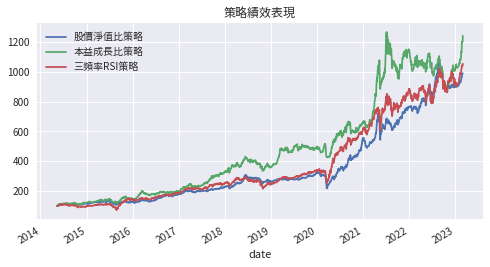

In [ ]:
portfolioPrice.plot(title="策略績效表現")

## 權重配置相關範例程式碼
1. 若資產配置權重變動過於劇烈，實際上該如何執行再平衡?
2. 該如何找到目前資產配置的各策略持有比重?

In [ ]:
# 簡單資產配置範例程式碼，使用全預設參數
finalPortfolioPrice = pd.read_csv(folder_path+"my_portfolioPrice.csv",index_col=0)
finalPortfolioPrice.index = pd.to_datetime(finalPortfolioPrice.index)
returns = finalPortfolioPrice.to_returns().dropna()
randomParamDict = {}

# Ans1 : 可透過降低再平衡的頻率(調整freq變數)，來降低再平衡的困難度 & 手續費損耗
creturn, weights_history = walkForwardBacktest(returns,**randomParamDict, freq=90) # 從20天再平衡拉長至90天

# Ans2 : 變數weights_history即為每次再平衡的權重
print("\n\n近期應調整成的資產配置部位:\n\n", weights_history.iloc[-1,:])
weights_history.tail(5)

Start Backtesting:  {}


近期應調整成的資產配置部位:

 股價淨值比策略     0.326164
本益成長比策略     0.470862
三頻率RSI策略    0.202974
Name: 2022-09-27 00:00:00, dtype: float64


,股價淨值比策略,本益成長比策略,三頻率RSI策略
2015-02-06,0.655010,0.178900,0.166090
2015-05-07,0.601816,0.215742,0.182442
2015-08-05,0.357126,0.445655,0.197219
2015-11-03,0.492183,0.323430,0.184388
2016-02-01,0.534354,0.285964,0.179682


## 將資產配置組合做成一個策略上傳至FinLab平台
+ 由於不同策略間的resample、進出場時間、停損點設定等等，與資產配置的再平衡時間並不相同，因此模擬與實際上會存在些許差距，合成出來的position僅作為參考使用。
+ 操作上建議策略的resample時間相同，並將資產配置的再平衡時間設定為策略再平衡時間的整數倍，可縮小上述差異。

In [ ]:
# 沿用上述程式碼「如何使用自己策略製作portfolioPrice.csv?」所產生的策略回測報告: r1,r2,r3
d = dict(zip(weights_history.columns, [r1,r2,r3]))
new_position = []

# 將各策略的經過資產配置的資金比重，分別乘上各自策略的position，得到每隻股票該買的真正比例
for strategy_name,r in d.items():
  w = weights_history[strategy_name].reindex(r.position.index, method='ffill').dropna()
  s = (r.position.mul(w,axis=0)).dropna(how='all')
  new_position.append(s)

In [ ]:
# 將position加總之後，使用FinLab模組回測
total_position = new_position[0] + new_position[1] + new_position[2]
sim(total_position)

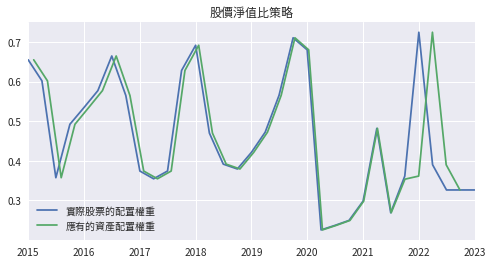

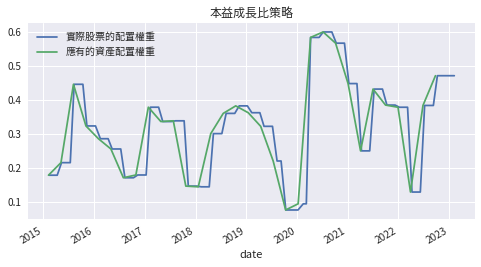

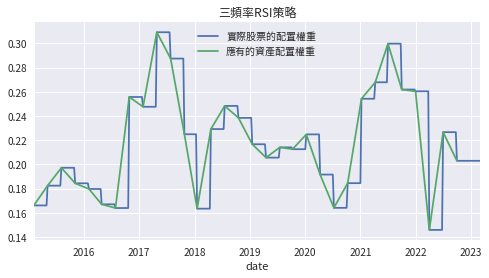

In [ ]:
# 由於不同策略間的resample進出場時間 & 資產配置的再平衡時間並不相同，因此模擬與實際上會存在些許差距
for i in range(3):
  new_position[i].sum(1).plot(label="實際股票的配置權重")
  weights_history[weights_history.columns[i]].plot(label="應有的資產配置權重")
  plt.title(weights_history.columns[i])
  plt.legend()
  plt.show()